<a href="https://colab.research.google.com/github/fannijako/ML_course_hws/blob/main/ML_3_hf_Fanni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London (vagy Mosonmagyaróvár) időjárásának előrejelzése

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [32]:
uploaded = files.upload()

Saving monthly_averages.csv to monthly_averages (3).csv
Saving weather_data_1hr.csv to weather_data_1hr (3).csv
Saving weather_data_24hr.csv to weather_data_24hr (3).csv
Saving yearly_monthly_averages.csv to yearly_monthly_averages (3).csv


In [33]:
month = pd.read_csv("monthly_averages.csv")
hour = pd.read_csv("weather_data_1hr.csv")
day = pd.read_csv("weather_data_24hr.csv")
year = pd.read_csv("yearly_monthly_averages.csv")

In [34]:
hour.shape

(1464, 31)

In [35]:
hour.head()

,loc_id,date,time,isdaytime,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,winddir16point,...,HeatIndexC,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF
0,1,2019-06-01,0,no,16,61,6,10,228,SW,...,16,61,12,54,16,61,7,12,16,61
1,1,2019-06-01,100,no,16,60,6,9,230,SW,...,16,60,12,53,16,60,7,11,16,60
2,1,2019-06-01,200,no,15,59,5,9,233,SW,...,15,59,11,53,15,59,6,10,15,59
3,1,2019-06-01,300,no,15,58,5,8,235,SW,...,15,58,11,52,14,58,6,9,14,58
4,1,2019-06-01,400,no,15,59,4,7,229,SW,...,15,59,11,52,15,59,5,8,15,59


In [36]:
sum(hour.loc_id == 1) == hour.shape[0]

True

felesleges oszlopok: 

- loc_id
- isdaytime
- tempC (ugyanazt az információt tartalmazza, mint tempF, csak kevésbé értelmes a skála nullpontja)
- windspeedMiles (ugyanazt azt információt tartalmazza, mint windspeedKmph)
- weatherIconUrl
- precipInches
- visibilityMiles
- pressureInches
- HeatIndexC
- DewPointC
- WindChillC
- WindGustMiles
- FeelsLikeC

In [37]:
hour = hour.drop(columns = ['loc_id', 
                            'isdaytime', 
                            'tempC', 
                            'windspeedMiles', 
                            'weatherIconUrl', 
                            'precipInches', 
                            'visibilityMiles', 
                            'pressureInches', 
                            'HeatIndexC', 
                            'DewPointC', 
                            'WindChillC', 
                            'WindGustMiles', 
                            'FeelsLikeC'])

In [38]:
hour.isna().sum()

date              0
time              0
tempF             0
windspeedKmph     0
winddirdegree     0
winddir16point    0
weatherCode       0
weatherDesc       0
precipMM          0
humidity          0
visibilityKm      0
pressureMB        0
cloudcover        0
HeatIndexF        0
DewPointF         0
WindChillF        0
WindGustKmph      0
FeelsLikeF        0
dtype: int64

In [39]:
pd.unique(hour.winddir16point)

array(['SW', 'SSW', 'S', 'SSE', 'WSW', 'W', 'SE', 'ESE', 'E', 'NNE', 'N',
       'NNW', 'NE', 'ENE', 'NW', 'WNW'], dtype=object)

In [40]:
pd.unique(hour.weatherCode)

array([116, 119, 122, 266, 353, 176, 302, 299, 296, 308, 293, 356, 389,
       359, 113])

In [41]:
pd.unique(hour.weatherDesc)

array(['Partly cloudy', 'Cloudy', 'Overcast', 'Light drizzle',
       'Light rain shower', 'Patchy rain possible', 'Moderate rain',
       'Moderate rain at times', 'Light rain', 'Heavy rain',
       'Patchy light rain', 'Moderate or heavy rain shower',
       'Moderate or heavy rain with thunder', 'Torrential rain shower',
       'Clear', 'Sunny'], dtype=object)

In [42]:
wind = pd.get_dummies(hour.winddir16point)
hour = pd.concat([hour, wind], axis = 1)

cloud = pd.get_dummies(hour.weatherDesc)
hour = pd.concat([hour, cloud], axis = 1)

In [43]:
hour.groupby(['weatherCode']).mean()

,time,tempF,windspeedKmph,winddirdegree,precipMM,humidity,visibilityKm,pressureMB,cloudcover,HeatIndexF,...,Moderate or heavy rain shower,Moderate or heavy rain with thunder,Moderate rain,Moderate rain at times,Overcast,Partly cloudy,Patchy light rain,Patchy rain possible,Sunny,Torrential rain shower
weatherCode,,,,,,,,,,,,,,,,,,,,,
113,1064.285714,74.928571,12.309524,167.309524,0.000000,54.809524,10.000000,1017.952381,1.690476,76.357143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0
116,1090.163934,66.871585,12.512295,188.237705,0.000000,60.834699,10.949454,1017.091530,27.627049,67.662568,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0
119,1346.153846,67.358974,14.692308,210.341880,0.000000,58.367521,11.230769,1014.008547,71.316239,68.282051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
122,1122.916667,64.368056,12.236111,196.826389,0.000000,65.472222,11.076389,1015.444444,92.437500,65.243056,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
176,1208.474576,65.192090,14.338983,203.000000,0.104520,65.745763,10.514124,1013.502825,77.163842,66.254237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0
266,1200.000000,62.444444,13.472222,135.333333,0.136111,73.944444,4.805556,1012.666667,96.666667,63.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
293,1050.000000,58.000000,25.500000,193.333333,0.583333,68.666667,8.666667,1002.333333,78.833333,58.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0
296,850.000000,60.208333,13.208333,172.666667,0.387500,73.000000,9.541667,1011.208333,97.750000,60.291667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
299,1200.000000,61.555556,9.555556,203.888889,1.355556,74.333333,8.222222,1008.111111,72.555556,61.555556,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0


ez alapján a weatherCode és a WeatherDesc változók majdnem teljesen ugyanazt írják le, ezért a weatherCode változót is törlöm, az átalakított változókkal egyetemben

In [44]:
hour = hour.drop(columns = ['weatherCode', 'winddir16point', 'weatherDesc', 'date'])

In [45]:
hour.head()

,time,tempF,windspeedKmph,winddirdegree,precipMM,humidity,visibilityKm,pressureMB,cloudcover,HeatIndexF,...,Moderate or heavy rain shower,Moderate or heavy rain with thunder,Moderate rain,Moderate rain at times,Overcast,Partly cloudy,Patchy light rain,Patchy rain possible,Sunny,Torrential rain shower
0,0,61,10,228,0.0,77,10,1023,7,61,...,0,0,0,0,0,1,0,0,0,0
1,100,60,9,230,0.0,78,10,1023,6,60,...,0,0,0,0,0,1,0,0,0,0
2,200,59,9,233,0.0,79,10,1022,5,59,...,0,0,0,0,0,1,0,0,0,0
3,300,58,8,235,0.0,79,10,1022,4,58,...,0,0,0,0,0,1,0,0,0,0
4,400,59,7,229,0.0,77,10,1022,4,59,...,0,0,0,0,0,1,0,0,0,0


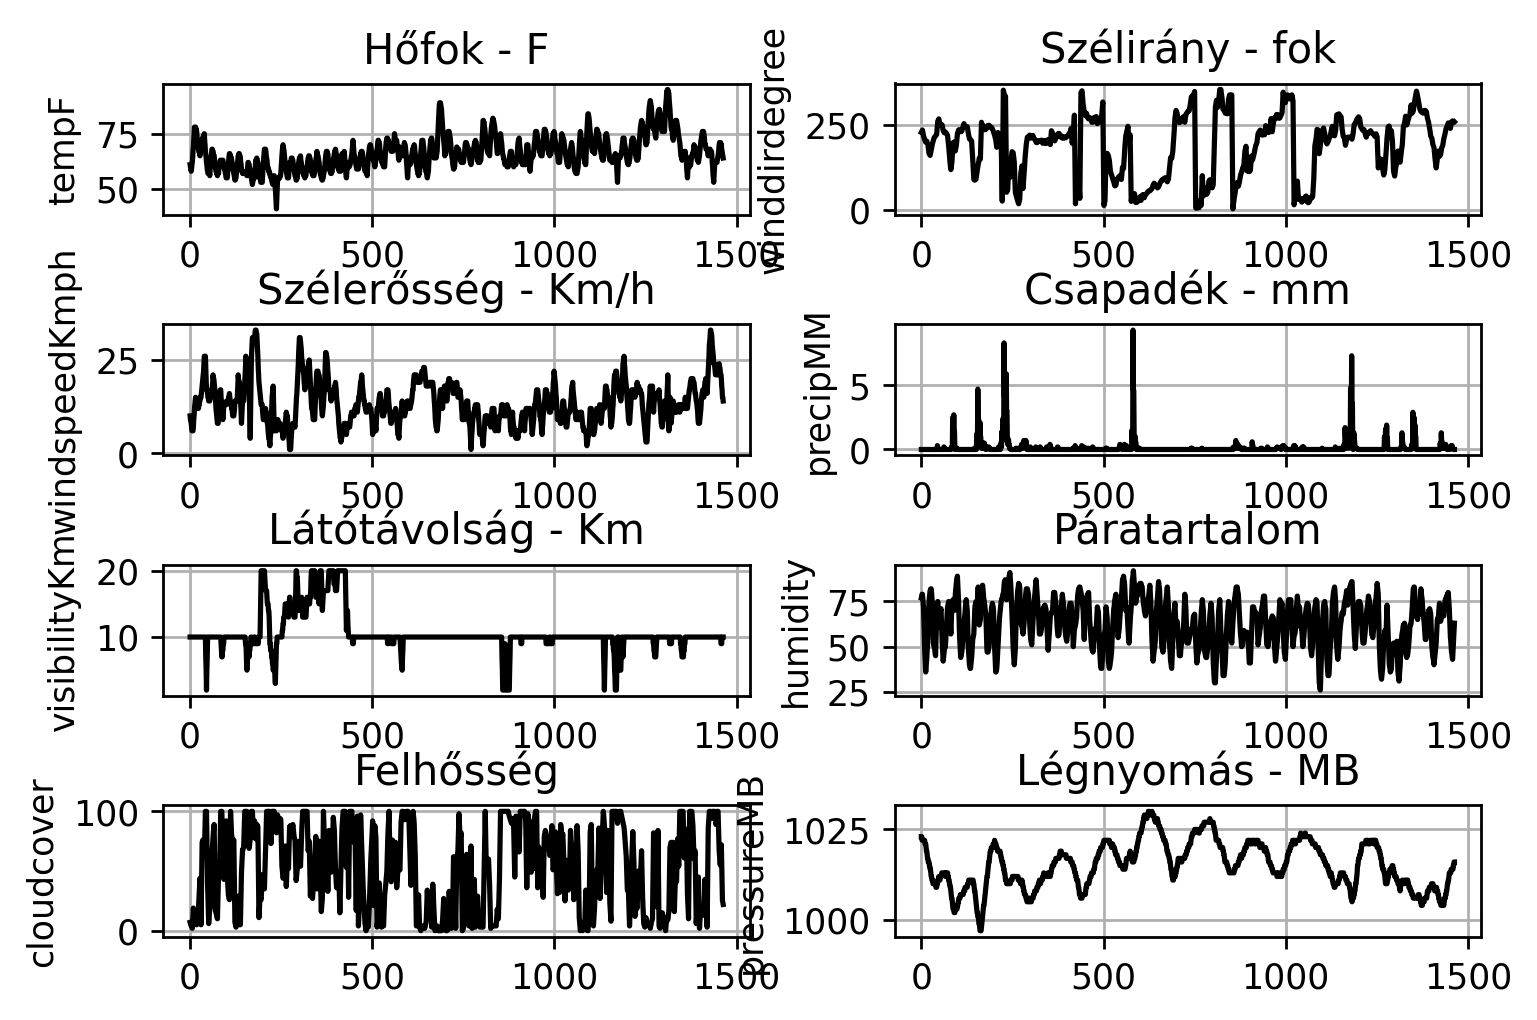

In [46]:
x = np.linspace(start = 0, stop = hour.shape[0], num = hour.shape[0], endpoint = False)

fig, ax = plt.subplots(4, 2)
fig.set_dpi(250)
fig.tight_layout()

ax[0, 0].plot(x, hour.tempF, 'k')
ax[0, 0].set(ylabel='tempF', title='Hőfok - F')
ax[0, 0].grid()

ax[1, 0].plot(x, hour.windspeedKmph, 'k')
ax[1, 0].set(ylabel='windspeedKmph', title='Szélerősség - Km/h')
ax[1, 0].grid()

ax[0, 1].plot(x, hour.winddirdegree, 'k')
ax[0, 1].set(ylabel='winddirdegree', title='Szélirány - fok')
ax[0, 1].grid()

ax[1, 1].plot(x, hour.precipMM, 'k')
ax[1, 1].set(ylabel='precipMM', title='Csapadék - mm')
ax[1, 1].grid()

ax[2, 1].plot(x, hour.humidity, 'k')
ax[2, 1].set(ylabel='humidity', title='Páratartalom')
ax[2, 1].grid()

ax[2, 0].plot(x, hour.visibilityKm, 'k')
ax[2, 0].set(ylabel='visibilityKm', title='Látótávolság - Km')
ax[2, 0].grid()

ax[3, 1].plot(x, hour.pressureMB, 'k')
ax[3, 1].set(ylabel='pressureMB', title='Légnyomás - MB')
ax[3, 1].grid()

ax[3, 0].plot(x, hour.cloudcover, 'k')
ax[3, 0].set(ylabel='cloudcover', title='Felhősség')
ax[3, 0].grid()

plt.show()

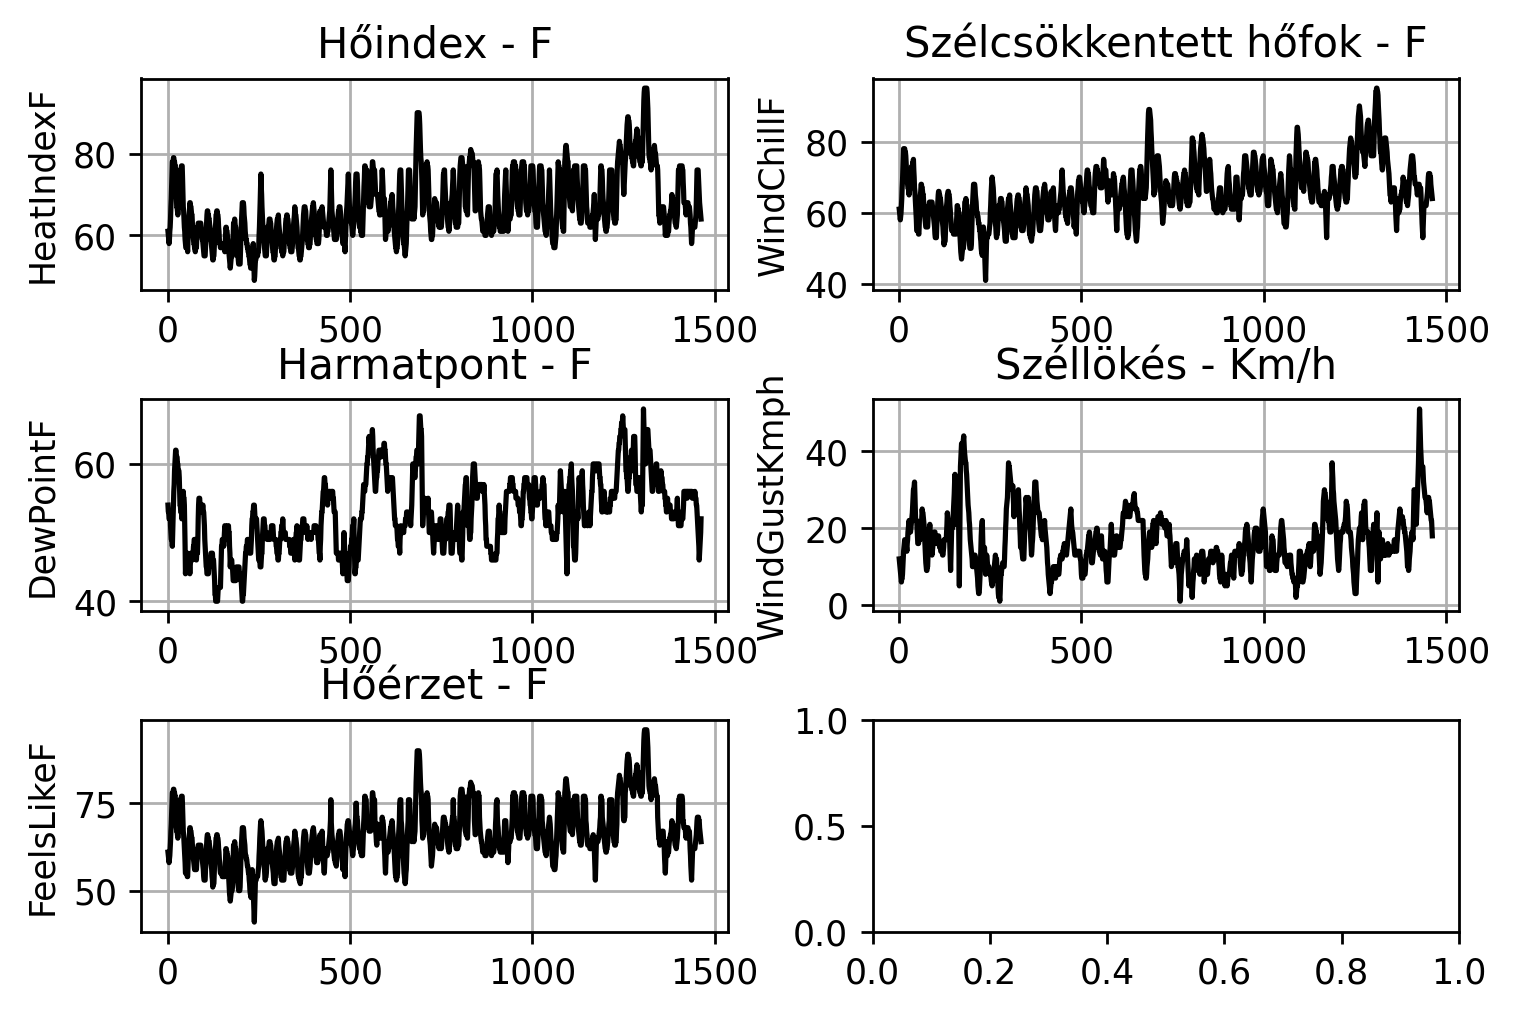

In [47]:
x = np.linspace(start = 0, stop = hour.shape[0], num = hour.shape[0], endpoint = False)

fig, ax = plt.subplots(3, 2)
fig.set_dpi(250)
fig.tight_layout()

ax[0, 0].plot(x, hour.HeatIndexF, 'k')
ax[0, 0].set(ylabel='HeatIndexF', title='Hőindex - F')
ax[0, 0].grid()

ax[1, 0].plot(x, hour.DewPointF, 'k')
ax[1, 0].set(ylabel='DewPointF', title='Harmatpont - F')
ax[1, 0].grid()

ax[0, 1].plot(x, hour.WindChillF, 'k')
ax[0, 1].set(ylabel='WindChillF', title='Szélcsökkentett hőfok - F')
ax[0, 1].grid()

ax[1, 1].plot(x, hour.WindGustKmph, 'k')
ax[1, 1].set(ylabel='WindGustKmph', title='Széllökés - Km/h')
ax[1, 1].grid()

ax[2, 0].plot(x, hour.FeelsLikeF, 'k')
ax[2, 0].set(ylabel='FeelsLikeF', title='Hőérzet - F')
ax[2, 0].grid()

plt.show()

## Előrejelzés a következő órára

Célváltozó: hőmérséklet (tempF)

Magyarázóváltozók: 1 órával korábbi értékek

In [48]:
x_train = hour.loc[0:(hour.shape[0] - 6*24 - 2),:]
y_train = hour.loc[1:(hour.shape[0] - 6*24 - 1), 'tempF']
x_test = hour.loc[(hour.shape[0] - 6*24 - 1):hour.shape[0] - 2,:]
y_test = hour.loc[(hour.shape[0] - 6*24): hour.shape[0], 'tempF']

normalizer = StandardScaler()
normalizer.fit(x_train)
x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)

input = Input(shape=(x_train.shape[1]))
x = Dropout(0.4, input_shape=input.shape)
x = Dense(128, activation='relu')(input)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = keras.Model(input, output)

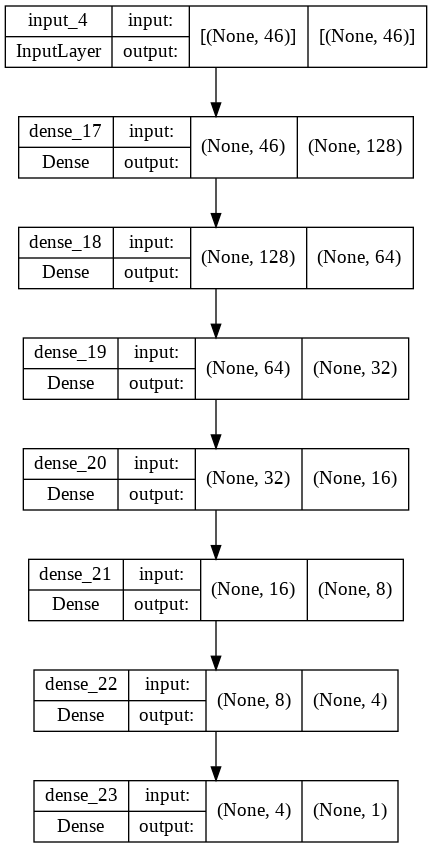

In [49]:
plot_model(model, show_shapes=True)

In [50]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=['MSE'])
early_stopping_callback = EarlyStopping(patience=20, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=64, epochs=500, validation_split=0.1, callbacks=[early_stopping_callback])

Epoch 1/500
19/19 [==============================] - 1s 27ms/step - loss: 4220.3940 - MSE: 4220.3940 - val_loss: 5777.0894 - val_MSE: 5777.0894
Epoch 2/500
19/19 [==============================] - 0s 7ms/step - loss: 3974.0378 - MSE: 3974.0378 - val_loss: 5159.7568 - val_MSE: 5159.7568
Epoch 3/500
19/19 [==============================] - 0s 7ms/step - loss: 2779.0835 - MSE: 2779.0835 - val_loss: 2388.2722 - val_MSE: 2388.2722
Epoch 4/500
19/19 [==============================] - 0s 8ms/step - loss: 551.3633 - MSE: 551.3633 - val_loss: 166.0356 - val_MSE: 166.0356
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 111.6503 - MSE: 111.6503 - val_loss: 144.4370 - val_MSE: 144.4370
Epoch 6/500
19/19 [==============================] - 0s 8ms/step - loss: 54.2288 - MSE: 54.2288 - val_loss: 111.0474 - val_MSE: 111.0474
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 31.8353 - MSE: 31.8353 - val_loss: 104.4105 - val_MSE: 104.4105
Epoch 8/500
19/19 

In [51]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 7.9621 - MSE: 7.9621


[7.962138652801514, 7.962138652801514]

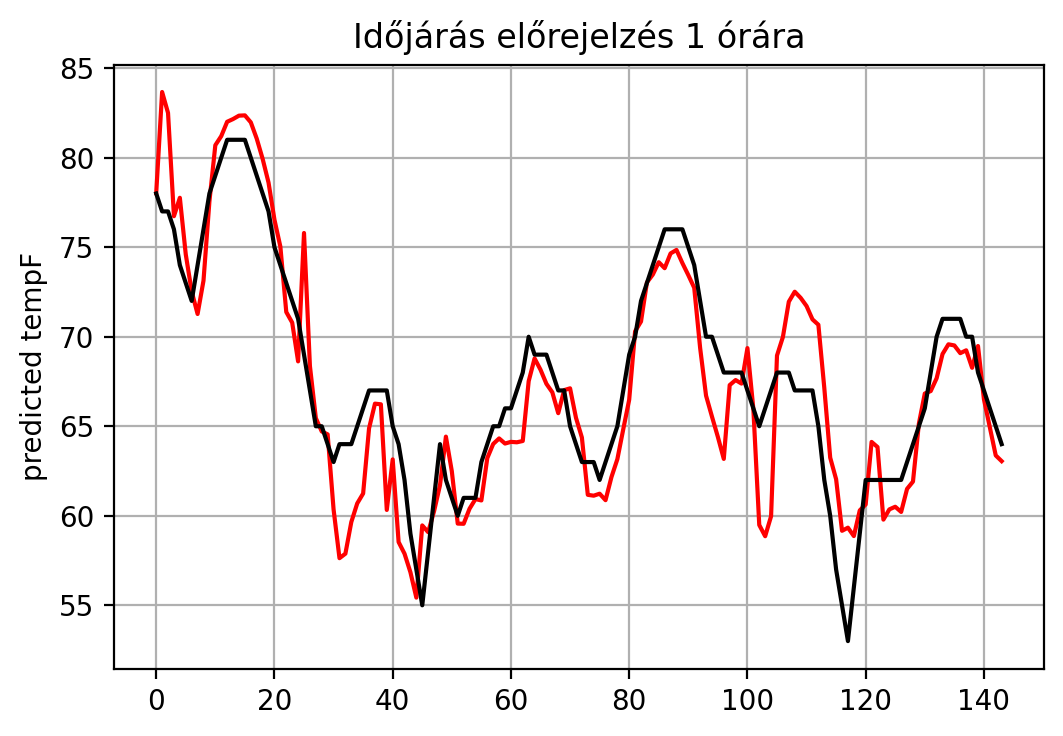

In [52]:
x = np.linspace(start = 0, stop = 144, num = 144, endpoint = False)
y = model.predict(x_test)

fig, ax = plt.subplots()
fig.set_dpi(200)
ax.plot(x, y, 'r')
ax.plot(x, y_test, 'k')

ax.set(ylabel='predicted tempF', title='Időjárás előrejelzés 1 órára')
ax.grid()

plt.show()

## Két órányi információval

Epoch 1/500
19/19 [==============================] - 1s 20ms/step - loss: 1382.9817 - MSE: 1382.9817 - val_loss: 475.3333 - val_MSE: 475.3333
Epoch 2/500
19/19 [==============================] - 0s 8ms/step - loss: 155.8914 - MSE: 155.8914 - val_loss: 136.0859 - val_MSE: 136.0859
Epoch 3/500
19/19 [==============================] - 0s 7ms/step - loss: 46.4123 - MSE: 46.4123 - val_loss: 109.1913 - val_MSE: 109.1913
Epoch 4/500
19/19 [==============================] - 0s 7ms/step - loss: 23.1368 - MSE: 23.1368 - val_loss: 75.5177 - val_MSE: 75.5177
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 13.8276 - MSE: 13.8276 - val_loss: 62.9870 - val_MSE: 62.9870
Epoch 6/500
19/19 [==============================] - 0s 10ms/step - loss: 10.2200 - MSE: 10.2200 - val_loss: 58.1077 - val_MSE: 58.1077
Epoch 7/500
19/19 [==============================] - 0s 11ms/step - loss: 7.8215 - MSE: 7.8215 - val_loss: 61.0085 - val_MSE: 61.0085
Epoch 8/500
19/19 [=======================

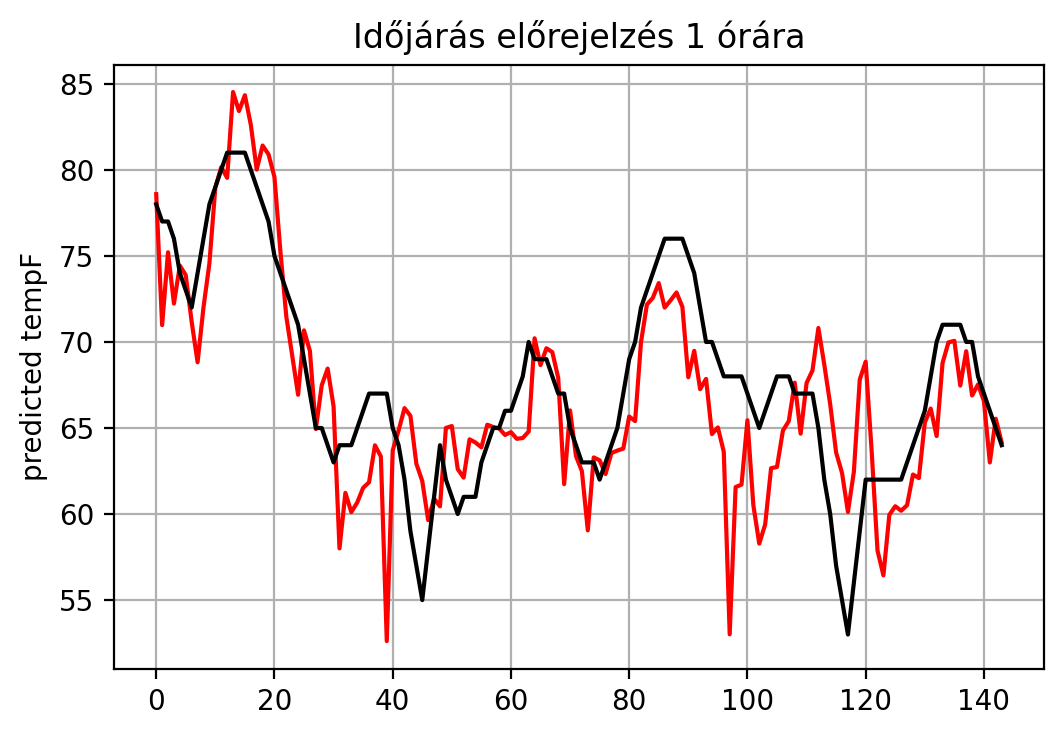

In [53]:
x_train_1 = hour.loc[0:(hour.shape[0] - 6*24 - 3),:].reset_index(drop = True)
x_train_2 = hour.loc[1:(hour.shape[0] - 6*24 - 2),:].reset_index(drop = True)
x_train = pd.concat([x_train_1, x_train_2], axis = 1)

y_train = hour.loc[2:(hour.shape[0] - 6*24 - 1), 'tempF']

x_test_1 = hour.loc[(hour.shape[0] - 2 - 6*24):hour.shape[0] - 3,:].reset_index(drop = True)
x_test_2 = hour.loc[(hour.shape[0] - 1 - 6*24):hour.shape[0] - 2,:].reset_index(drop = True)
x_test = pd.concat([x_test_1, x_test_2], axis = 1)

y_test = hour.loc[(hour.shape[0] - 6*24):hour.shape[0] - 1, 'tempF'].reset_index(drop = True)

normalizer = StandardScaler()
normalizer.fit(x_train)
x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)

input = Input(shape=(x_train.shape[1]))
x = Dropout(0.4, input_shape=input.shape)
x = Dense(128, activation='relu')(input)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)
x = Dense(2, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = keras.Model(input, output)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.025),
              loss = 'MSE',
              metrics = ['MSE'])
early_stopping_callback = EarlyStopping(patience=20, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=64, epochs=500, validation_split=0.1, callbacks=[early_stopping_callback])

print(model.evaluate(x_test, y_test))

x = np.linspace(start = 0, stop = 144, num = 144, endpoint = False)
y = model.predict(x_test)

fig, ax = plt.subplots()
fig.set_dpi(200)
ax.plot(x, y, 'r')
ax.plot(x, y_test, 'k')

ax.set(ylabel='predicted tempF', title='Időjárás előrejelzés 1 órára')
ax.grid()

plt.show()

# Előrejelzés 1 napra

In [54]:
day.shape

(61, 38)

In [55]:
day.head()

,loc_id,date,maxtempC,maxtempF,mintempC,mintempF,avgtempC,avgtempF,totalprecipMM,totalprecipIn,...,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,sunrise,sunset,moonrise,moonset
0,1,2019-06-01,26,78,15,58,22,72,0.0,0.00,...,21,69,7,12,21,70,03:49 AM,08:08 PM,03:12 AM,05:45 PM
1,1,2019-06-02,24,75,17,62,22,71,0.5,0.02,...,20,69,15,23,20,69,03:49 AM,08:09 PM,03:37 AM,06:59 PM
2,1,2019-06-03,20,68,14,56,18,64,0.5,0.02,...,16,61,12,20,16,61,03:48 AM,08:10 PM,04:08 AM,08:13 PM
3,1,2019-06-04,17,63,14,56,16,62,10.7,0.42,...,16,60,9,14,16,60,03:47 AM,08:11 PM,04:47 AM,09:23 PM
4,1,2019-06-05,19,66,13,55,17,62,0.1,0.00,...,15,60,10,17,15,60,03:47 AM,08:12 PM,05:38 AM,10:23 PM


In [56]:
sum(day.loc_id == 1) == day.shape[0]

True

In [57]:
day = day.drop(columns = ['loc_id', 
                            'maxtempC',
                            'mintempC',
                            'avgtempC', 
                            'windspeedMiles', 
                            'weatherIconUrl', 
                            'totalprecipIn', 
                            'visibilityMiles', 
                            'pressureInches', 
                            'HeatIndexC', 
                            'DewPointC', 
                            'WindChillC', 
                            'WindGustMiles', 
                            'FeelsLikeC',
                          'sunrise',
                          'sunset',
                          'moonrise',
                          'moonset'])

In [58]:
day.isna().sum()

date              0
maxtempF          0
mintempF          0
avgtempF          0
totalprecipMM     0
windspeedKmph     0
sunhour           0
winddirdegree     0
winddir16point    0
weatherCode       0
weatherDesc       0
humidity          0
visibilityKm      0
pressureMB        0
cloudcover        0
HeatIndexF        0
DewPointF         0
WindChillF        0
WindGustKmph      0
FeelsLikeF        0
dtype: int64

In [59]:
wind = pd.get_dummies(day.winddir16point)
day = pd.concat([day, wind], axis = 1)

cloud = pd.get_dummies(day.weatherDesc)
day = pd.concat([day, cloud], axis = 1)

day = day.drop(columns = ['weatherCode', 'winddir16point', 'weatherDesc', 'date'])

day.head()

,maxtempF,mintempF,avgtempF,totalprecipMM,windspeedKmph,sunhour,winddirdegree,humidity,visibilityKm,pressureMB,...,Cloudy,Light drizzle,Light rain shower,Moderate or heavy rain shower,Moderate or heavy rain with thunder,Moderate rain,Overcast,Partly cloudy,Patchy rain possible,Sunny
0,78,58,72,0.0,10,8.7,200,61,10,1020,...,0,0,0,0,0,0,0,1,0,0
1,75,62,71,0.5,19,3.3,215,66,9,1011,...,0,0,0,0,0,0,1,0,0,0
2,68,56,64,0.5,17,5.1,235,57,10,1012,...,0,0,1,0,0,0,0,0,0,0
3,63,56,62,10.7,12,5.1,164,71,9,1007,...,0,0,1,0,0,0,0,0,0,0
4,66,55,62,0.1,13,6.9,236,64,10,1006,...,0,0,0,0,0,0,1,0,0,0


Epoch 1/500
3/3 [==============================] - 1s 113ms/step - loss: 4325.3667 - MSE: 4325.3667 - val_loss: 5962.3413 - val_MSE: 5962.3413
Epoch 2/500
3/3 [==============================] - 0s 18ms/step - loss: 4262.4976 - MSE: 4262.4976 - val_loss: 5931.8979 - val_MSE: 5931.8979
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 4199.8125 - MSE: 4199.8125 - val_loss: 5897.6426 - val_MSE: 5897.6426
Epoch 4/500
3/3 [==============================] - 0s 20ms/step - loss: 4134.2065 - MSE: 4134.2065 - val_loss: 5865.3491 - val_MSE: 5865.3491
Epoch 5/500
3/3 [==============================] - 0s 40ms/step - loss: 4063.7109 - MSE: 4063.7109 - val_loss: 5835.3257 - val_MSE: 5835.3257
Epoch 6/500
3/3 [==============================] - 0s 42ms/step - loss: 3986.8896 - MSE: 3986.8896 - val_loss: 5806.8950 - val_MSE: 5806.8950
Epoch 7/500
3/3 [==============================] - 0s 22ms/step - loss: 3904.4070 - MSE: 3904.4070 - val_loss: 5784.2397 - val_MSE: 5784.2397
Epoch

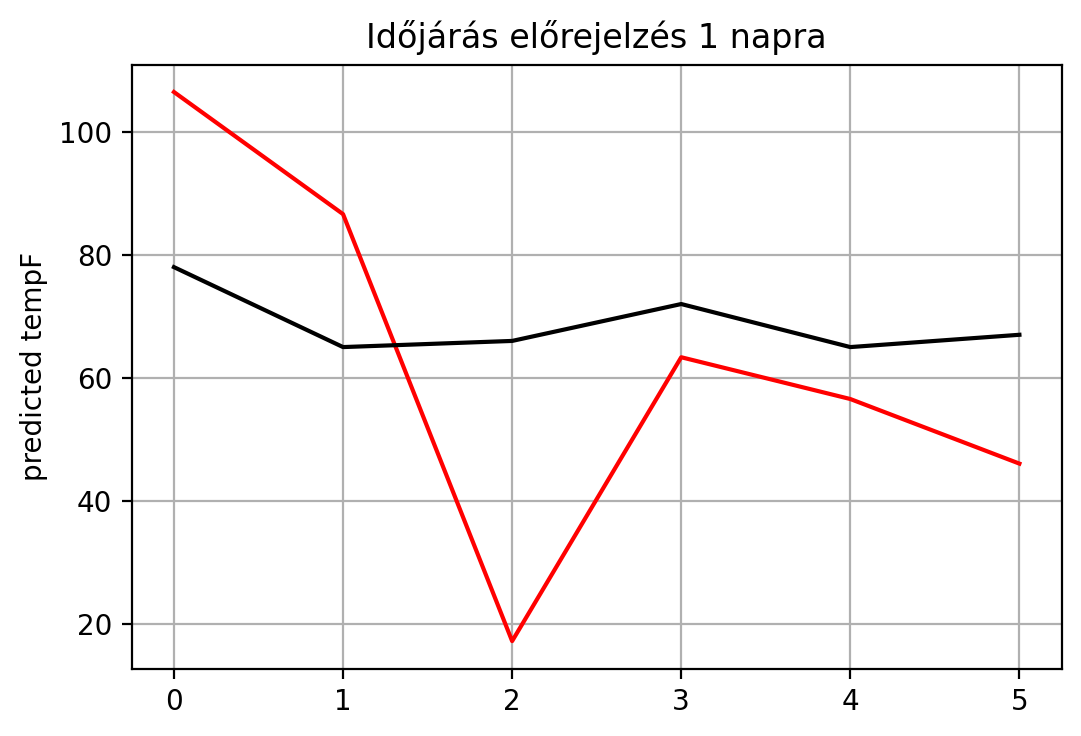

In [60]:
x_train = day.loc[0:(day.shape[0] - 6 - 2),:]
y_train = day.loc[1:(day.shape[0] - 6 - 1), 'avgtempF']
x_test = day.loc[(day.shape[0] - 6 - 1):day.shape[0] - 2,:]
y_test = day.loc[(day.shape[0] - 6): day.shape[0], 'avgtempF']

normalizer = StandardScaler()
normalizer.fit(x_train)
x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)

input = Input(shape=(x_train.shape[1]))
x = Dropout(0.1, input_shape=input.shape)
x = Dense(8, activation='relu')(input)
output = Dense(1, activation='linear')(x)

model = keras.Model(input, output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='MSE',
              metrics=['MSE'])
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=16, epochs=500, validation_split=0.1, callbacks=[early_stopping_callback])

model.evaluate(x_test, y_test)

x = np.linspace(start = 0, stop = 6, num = 6, endpoint = False)
y = model.predict(x_test)

fig, ax = plt.subplots()
fig.set_dpi(200)
ax.plot(x, y, 'r')
ax.plot(x, y_test, 'k')

ax.set(ylabel='predicted tempF', title='Időjárás előrejelzés 1 napra')
ax.grid()

plt.show()